In [1]:
import argparse
import logging
import os
import shutil
from datetime import datetime, timedelta
from typing import List

import torch
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm

from models.MiDas import MidasNet
from models.TernausNet import UNet16 

from datasets import BaseDepthDataset, DatasetMode, get_dataset
from datasets.mixed_sampler import MixedBatchSampler
from trainers.mytrainer import NetTrainer
from util.config_util import (
    find_value_in_omegaconf,
    recursive_load_config,
)
from util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from util.logging_util import(
  config_logging
)

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class args:
    def __init__(self) -> None:
        self.config = "config/test_rel.yaml"
        self.resume_run = None # './test/checkpoint/latest'
        self.output_dir = "./" # "/content/drive/MyDrive/magisterka"
        self.base_data_dir = 'C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001'
        self.add_datetime_prefix = False
        self.exit_after = -1
        self.no_cuda = False

args = args()

resume_run = args.resume_run
output_dir = args.output_dir
base_data_dir = (
    args.base_data_dir
    if args.base_data_dir is not None
    else os.environ["BASE_DATA_DIR"]
)
t_start = datetime.now()
# Resume previous run
if resume_run is not None:
    print(f"Resume run: {resume_run}")
    out_dir_run = os.path.dirname(os.path.dirname(resume_run))
    job_name = os.path.basename(out_dir_run)
    # Resume config file
    cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
else:
    # Run from start
    cfg = recursive_load_config(args.config)
    # Full job name
    pure_job_name = os.path.basename(args.config).split(".")[0]
    # Add time prefix
    if args.add_datetime_prefix:
        job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
    else:
        job_name = pure_job_name
    # Output dir
    if output_dir is not None:
        out_dir_run = os.path.join(output_dir, job_name)
    else:
        out_dir_run = os.path.join("./output", job_name)
    os.makedirs(out_dir_run, exist_ok=False)
cfg_data = cfg.dataset
# Other directories
out_dir_ckpt = os.path.join(out_dir_run, "checkpoint")
if not os.path.exists(out_dir_ckpt):
    os.makedirs(out_dir_ckpt)
out_dir_tr = os.path.join(out_dir_run, "training_record")
if not os.path.exists(out_dir_tr):
    os.makedirs(out_dir_tr)
out_dir_eval = os.path.join(out_dir_run, "evaluation_record")
if not os.path.exists(out_dir_eval):
    os.makedirs(out_dir_eval)
# -------------------- Logging settings --------------------
config_logging(cfg.logging, out_dir=out_dir_run)
logging.debug(f"config: {cfg}")
# -------------------- Device --------------------
cuda_avail = torch.cuda.is_available() and not args.no_cuda
device = torch.device("cuda" if cuda_avail else "cpu")
logging.info(f"device = {device}")
# -------------------- Snapshot of code and config --------------------
if resume_run is None:
    _output_path = os.path.join(out_dir_run, "config.yaml")
    with open(_output_path, "w+") as f:
        OmegaConf.save(config=cfg, f=f)
    logging.info(f"Config saved to {_output_path}")
    # Copy and tar code on the first run
    _temp_code_dir = os.path.join(out_dir_run, "code_tar")
    _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
    os.system(
        f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
    )
    os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
    os.system(f"rm -rf {_temp_code_dir}")
    logging.info(f"Code snapshot saved to: {_code_snapshot_path}")
# -------------------- Data --------------------
loader_seed = cfg.dataloader.seed
if loader_seed is None:
    loader_generator = None
else:
    loader_generator = torch.Generator().manual_seed(loader_seed)

# Training dataset
depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)
train_dataset: BaseDepthDataset = get_dataset(
    cfg_data.train,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    augmentation_args=cfg.augmentation_args,
    depth_transform=depth_transform,
)
logging.debug("Augmentation: ", cfg.augmentation_args)
if "mixed" == cfg_data.train.name:
    dataset_ls = train_dataset
    assert len(cfg_data.train.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.train_batch_size,
        drop_last=True,
        prob=cfg_data.train.prob_ls,
        shuffle=True,
        generator=loader_generator,
    )
    train_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.dataloader.train_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True,
        generator=loader_generator,
    )
# Validation dataset
val_dataset: BaseDepthDataset = get_dataset(
    cfg_data.val,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    depth_transform=depth_transform,
)
if "mixed" == cfg_data.val.name:
    dataset_ls = val_dataset
    assert len(cfg_data.val.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.val_batch_size,
        drop_last=True,
        prob=cfg_data.val.prob_ls,
        shuffle=False,
        generator=loader_generator,
    )
    val_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=cfg.dataloader.val_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=False,
        generator=loader_generator,
    )
# Test dataset
test_loaders: List[DataLoader] = []
for _test_dic in cfg_data.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        depth_transform=depth_transform,
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
    )
    test_loaders.append(_test_loader)
# -------------------- Model --------------------
if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError
# -------------------- Trainer --------------------
# Exit time
if args.exit_after > 0:
    t_end = t_start + timedelta(minutes=args.exit_after)
    logging.info(f"Will exit at {t_end}")
else:
    t_end = None
logging.debug(f"Trainer: treiner_nets")
trainer = NetTrainer(
    cfg=cfg,
    model=model,
    train_dataloader=train_loader,
    device=device,
    out_dir_ckpt=out_dir_ckpt,
    out_dir_tr=out_dir_tr,
    out_dir_eval=out_dir_eval,
    val_dataloader=val_loader,
    test_dataloaders=test_loaders,
)
# -------------------- Checkpoint --------------------
if resume_run is not None:
    trainer.load_checkpoint(
        resume_run, load_trainer_state=True, resume_lr_scheduler=True
    )
# -------------------- Training & Evaluation Loop --------------------
try:
    trainer.train(t_end=t_end)
except Exception as e:
    logging.exception(e)

 2024-08-27 15:04:34,606 - INFO -1016247671.py - <module> >> device = cuda
 2024-08-27 15:04:34,622 - INFO -1016247671.py - <module> >> Config saved to ./test_rel\config.yaml
 2024-08-27 15:04:34,732 - INFO -1016247671.py - <module> >> Code snapshot saved to: ./test_rel\code_snapshot.tar


c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 2024-08-27 15:04:39,767 - INFO -mytrainer.py - train >> Start training


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 90%|█████████ | 9/10 [00:38<00:02,  2.35s/it]

 2024-08-27 15:05:20,992 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:05:22,370 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:05:22,448 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:41<00:00,  4.14s/it]

 2024-08-27 15:05:22,934 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:05:23,559 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:05:23,591 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

 2024-08-27 15:05:40,416 - INFO -mytrainer.py - validate >> Iter 10. Validation metrics on `nyu_v2`: abs_relative_difference: 580.235 | squared_relative_difference: 220.310 | rmse_linear: 0.069 | rmse_log: 0.399 | log10: 0.102 | delta1_acc: 0.029 | delta2_acc: 0.060 | delta3_acc: 0.089 | i_rmse: 20457.129 | silog_rmse: 38.881 | loss: 0.026
 2024-08-27 15:05:40,463 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 580.2345556640626 at iteration 10
 2024-08-27 15:05:40,478 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\iter_000010


 2024-08-27 15:05:41,247 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\iter_000010\net.pth
 2024-08-27 15:05:41,262 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:05:42,057 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:05:42,082 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:23<00:02,  2.48s/it]

 2024-08-27 15:06:06,997 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:06:08,047 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:06:08,079 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:25<00:00,  2.60s/it]

 2024-08-27 15:06:08,125 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:06:09,035 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:06:09,051 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

 2024-08-27 15:06:31,258 - INFO -mytrainer.py - validate >> Iter 20. Validation metrics on `nyu_v2`: abs_relative_difference: 580.712 | squared_relative_difference: 220.596 | rmse_linear: 0.069 | rmse_log: 0.399 | log10: 0.101 | delta1_acc: 0.029 | delta2_acc: 0.060 | delta3_acc: 0.089 | i_rmse: 20457.133 | silog_rmse: 38.867 | loss: 0.026
 2024-08-27 15:06:31,275 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:06:31,796 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:06:31,812 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:21<00:02,  2.28s/it]

 2024-08-27 15:06:54,572 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:06:55,237 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:06:55,268 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]

 2024-08-27 15:06:55,377 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:06:55,785 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:06:55,801 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]

 2024-08-27 15:07:08,877 - INFO -mytrainer.py - validate >> Iter 30. Validation metrics on `nyu_v2`: abs_relative_difference: 581.517 | squared_relative_difference: 221.078 | rmse_linear: 0.069 | rmse_log: 0.398 | log10: 0.101 | delta1_acc: 0.029 | delta2_acc: 0.060 | delta3_acc: 0.089 | i_rmse: 20457.142 | silog_rmse: 38.843 | loss: 0.026
 2024-08-27 15:07:08,893 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:07:09,411 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:07:09,443 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:21<00:02,  2.40s/it]

 2024-08-27 15:07:32,569 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:07:33,202 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:07:33,215 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]

 2024-08-27 15:07:33,272 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:07:33,712 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:07:33,728 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

 2024-08-27 15:07:50,062 - INFO -mytrainer.py - validate >> Iter 40. Validation metrics on `nyu_v2`: abs_relative_difference: 582.567 | squared_relative_difference: 221.701 | rmse_linear: 0.069 | rmse_log: 0.398 | log10: 0.101 | delta1_acc: 0.030 | delta2_acc: 0.060 | delta3_acc: 0.089 | i_rmse: 20457.151 | silog_rmse: 38.812 | loss: 0.026
 2024-08-27 15:07:50,078 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:07:50,518 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:07:50,533 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:19<00:02,  2.16s/it]

 2024-08-27 15:08:11,960 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:08:12,666 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:08:12,682 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

 2024-08-27 15:08:12,744 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:08:13,294 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:08:13,309 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

 2024-08-27 15:08:26,852 - INFO -mytrainer.py - validate >> Iter 50. Validation metrics on `nyu_v2`: abs_relative_difference: 583.844 | squared_relative_difference: 222.450 | rmse_linear: 0.069 | rmse_log: 0.397 | log10: 0.101 | delta1_acc: 0.030 | delta2_acc: 0.060 | delta3_acc: 0.089 | i_rmse: 20457.160 | silog_rmse: 38.772 | loss: 0.026
 2024-08-27 15:08:26,867 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:08:27,314 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:08:27,346 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:18<00:01,  1.98s/it]

 2024-08-27 15:08:46,949 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:08:47,791 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:08:47,808 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

 2024-08-27 15:08:47,864 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:08:48,455 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:08:48,479 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]

 2024-08-27 15:09:01,200 - INFO -mytrainer.py - validate >> Iter 60. Validation metrics on `nyu_v2`: abs_relative_difference: 585.237 | squared_relative_difference: 223.260 | rmse_linear: 0.069 | rmse_log: 0.397 | log10: 0.101 | delta1_acc: 0.030 | delta2_acc: 0.061 | delta3_acc: 0.089 | i_rmse: 20457.174 | silog_rmse: 38.728 | loss: 0.026
 2024-08-27 15:09:01,216 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:09:01,624 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:09:01,640 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:17<00:01,  1.92s/it]

 2024-08-27 15:09:20,196 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:09:20,821 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:09:20,821 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

 2024-08-27 15:09:20,884 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:09:21,261 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:09:21,276 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]

 2024-08-27 15:09:34,482 - INFO -mytrainer.py - validate >> Iter 70. Validation metrics on `nyu_v2`: abs_relative_difference: 587.143 | squared_relative_difference: 224.398 | rmse_linear: 0.069 | rmse_log: 0.396 | log10: 0.101 | delta1_acc: 0.030 | delta2_acc: 0.061 | delta3_acc: 0.089 | i_rmse: 20457.192 | silog_rmse: 38.668 | loss: 0.026
 2024-08-27 15:09:34,482 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:09:34,921 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:09:34,937 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:25<00:03,  3.48s/it]

 2024-08-27 15:10:02,575 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:10:03,379 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:03,411 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

 2024-08-27 15:10:03,442 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:10:04,070 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:04,094 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

 2024-08-27 15:10:18,077 - INFO -mytrainer.py - validate >> Iter 80. Validation metrics on `nyu_v2`: abs_relative_difference: 589.125 | squared_relative_difference: 225.564 | rmse_linear: 0.069 | rmse_log: 0.395 | log10: 0.100 | delta1_acc: 0.030 | delta2_acc: 0.061 | delta3_acc: 0.090 | i_rmse: 20457.205 | silog_rmse: 38.608 | loss: 0.026
 2024-08-27 15:10:18,094 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:10:18,618 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:18,655 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:25<00:02,  2.57s/it]

 2024-08-27 15:10:45,815 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:10:46,397 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:46,413 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

 2024-08-27 15:10:46,475 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:10:46,800 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:46,809 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]

 2024-08-27 15:10:59,495 - INFO -mytrainer.py - validate >> Iter 90. Validation metrics on `nyu_v2`: abs_relative_difference: 591.851 | squared_relative_difference: 227.211 | rmse_linear: 0.069 | rmse_log: 0.394 | log10: 0.100 | delta1_acc: 0.030 | delta2_acc: 0.061 | delta3_acc: 0.090 | i_rmse: 20457.221 | silog_rmse: 38.526 | loss: 0.026
 2024-08-27 15:10:59,511 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest


 2024-08-27 15:10:59,891 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:10:59,899 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:17<00:01,  1.96s/it]

 2024-08-27 15:11:19,279 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\latest
 2024-08-27 15:11:19,833 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\latest\net.pth
 2024-08-27 15:11:19,873 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_rel\checkpoint\latest\trainer.ckpt
 2024-08-27 15:11:19,914 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_rel\checkpoint\iter_000100
 2024-08-27 15:11:20,303 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_rel\checkpoint\iter_000100\net.pth
 2024-08-27 15:11:20,310 - INFO -mytrainer.py - train >> Training ended.


 90%|█████████ | 9/10 [00:20<00:02,  2.25s/it]


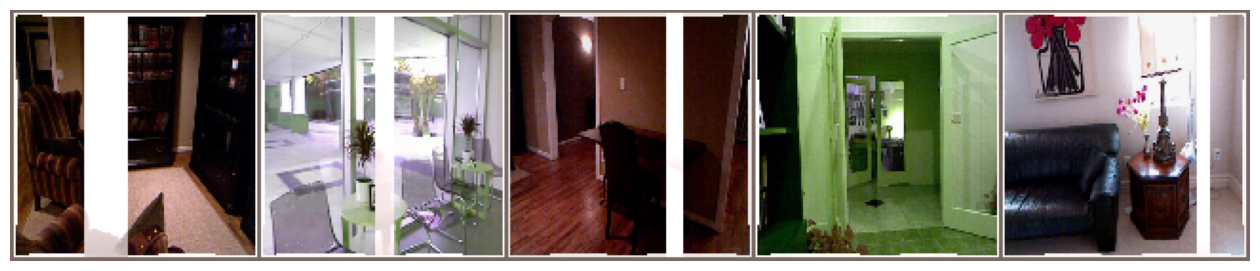

 2024-08-27 15:11:27,014 - WARNING -image.py - _normalize_image_array >> Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


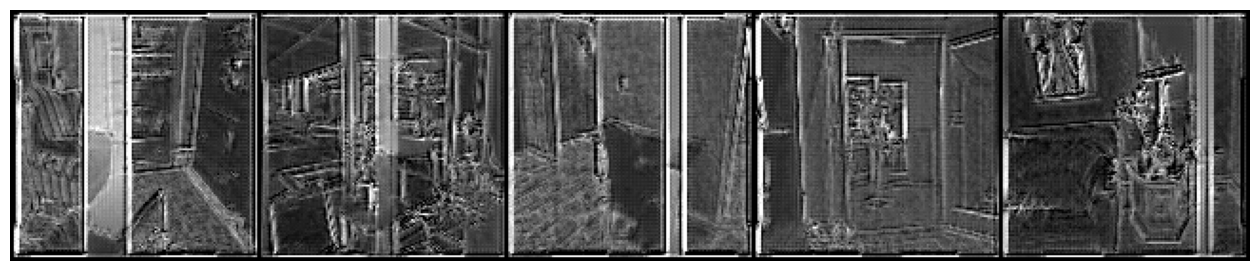

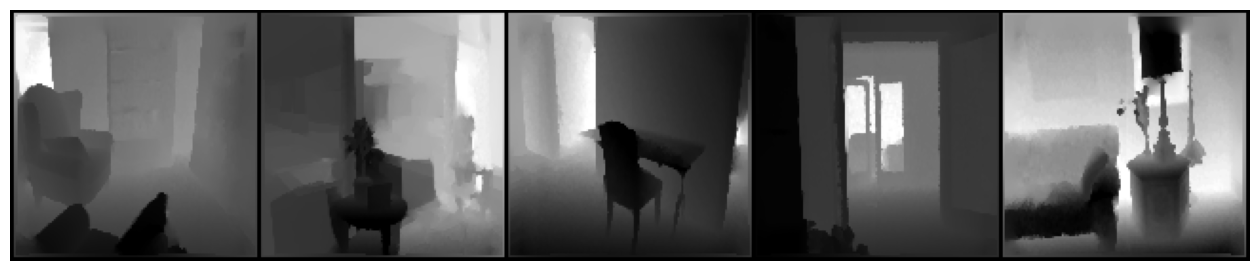

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imgshow(inp, title=None, pred=False):
    inp = inp.numpy().transpose((1, 2, 0))
    if not pred:
        mean = np.array([0.48012177, 0.41071795, 0.39187136])
        std = np.array([0.28875302, 0.29516797, 0.30792887])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# for samples, _ in iter(dataloaders['train']):
batch = next(iter(train_loader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['rgb_img'])
imgshow(grid_imgs)

pred_samples = model(batch['rgb_img'].to(device))

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(pred_samples.cpu())
imgshow(grid_imgs, pred=True)

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['depth_raw_norm'])
imgshow(grid_imgs, pred=True)

In [5]:
class args:
    def __init__(self) -> None:
        self.config = "config/test_abs.yaml"
        self.resume_run = None # './test_abs/checkpoint/latest'
        self.output_dir = "./" # "/content/drive/MyDrive/magisterka"
        self.base_data_dir = 'C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001'
        self.add_datetime_prefix = False
        self.exit_after = -1
        self.no_cuda = False

args = args()

resume_run = args.resume_run
output_dir = args.output_dir
base_data_dir = (
    args.base_data_dir
    if args.base_data_dir is not None
    else os.environ["BASE_DATA_DIR"]
)
t_start = datetime.now()
# Resume previous run
if resume_run is not None:
    print(f"Resume run: {resume_run}")
    out_dir_run = os.path.dirname(os.path.dirname(resume_run))
    job_name = os.path.basename(out_dir_run)
    # Resume config file
    cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
else:
    # Run from start
    cfg = recursive_load_config(args.config)
    # Full job name
    pure_job_name = os.path.basename(args.config).split(".")[0]
    # Add time prefix
    if args.add_datetime_prefix:
        job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
    else:
        job_name = pure_job_name
    # Output dir
    if output_dir is not None:
        out_dir_run = os.path.join(output_dir, job_name)
    else:
        out_dir_run = os.path.join("./output", job_name)
    os.makedirs(out_dir_run, exist_ok=False)
cfg_data = cfg.dataset
# Other directories
out_dir_ckpt = os.path.join(out_dir_run, "checkpoint")
if not os.path.exists(out_dir_ckpt):
    os.makedirs(out_dir_ckpt)
out_dir_tr = os.path.join(out_dir_run, "training_record")
if not os.path.exists(out_dir_tr):
    os.makedirs(out_dir_tr)
out_dir_eval = os.path.join(out_dir_run, "evaluation_record")
if not os.path.exists(out_dir_eval):
    os.makedirs(out_dir_eval)
# -------------------- Logging settings --------------------
config_logging(cfg.logging, out_dir=out_dir_run)
logging.debug(f"config: {cfg}")
# -------------------- Device --------------------
cuda_avail = torch.cuda.is_availabel() and not args.no_cuda
device = torch.device("cuda" if cuda_avail else "cpu")
logging.info(f"device = {device}")
# -------------------- Snapshot of code and config --------------------
if resume_run is None:
    _output_path = os.path.join(out_dir_run, "config.yaml")
    with open(_output_path, "w+") as f:
        OmegaConf.save(config=cfg, f=f)
    logging.info(f"Config saved to {_output_path}")
    # Copy and tar code on the first run
    _temp_code_dir = os.path.join(out_dir_run, "code_tar")
    _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
    os.system(
        f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
    )
    os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
    os.system(f"rm -rf {_temp_code_dir}")
    logging.info(f"Code snapshot saved to: {_code_snapshot_path}")
# -------------------- Data --------------------
loader_seed = cfg.dataloader.seed
if loader_seed is None:
    loader_generator = None
else:
    loader_generator = torch.Generator().manual_seed(loader_seed)
# Training dataset
depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)
train_dataset: BaseDepthDataset = get_dataset(
    cfg_data.train,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    augmentation_args=cfg.augmentation_args,
    depth_transform=depth_transform,
)
logging.debug("Augmentation: ", cfg.augmentation_args)
if "mixed" == cfg_data.train.name:
    dataset_ls = train_dataset
    assert len(cfg_data.train.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.train_batch_size,
        drop_last=True,
        prob=cfg_data.train.prob_ls,
        shuffle=True,
        generator=loader_generator,
    )
    train_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.dataloader.train_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True,
        generator=loader_generator,
    )
# Validation dataset
val_dataset: BaseDepthDataset = get_dataset(
    cfg_data.val,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    depth_transform=depth_transform,
)
if "mixed" == cfg_data.val.name:
    dataset_ls = val_dataset
    assert len(cfg_data.val.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.val_batch_size,
        drop_last=True,
        prob=cfg_data.val.prob_ls,
        shuffle=False,
        generator=loader_generator,
    )
    val_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
    )
else:
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=cfg.dataloader.val_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=False,
        generator=loader_generator,
    )
# Test dataset
test_loaders: List[DataLoader] = []
for _test_dic in cfg_data.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        depth_transform=depth_transform,
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
    )
    test_loaders.append(_test_loader)
# -------------------- Model --------------------
if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError
# -------------------- Trainer --------------------
# Exit time
if args.exit_after > 0:
    t_end = t_start + timedelta(minutes=args.exit_after)
    logging.info(f"Will exit at {t_end}")
else:
    t_end = None
logging.debug(f"Trainer: treiner_nets")
trainer = NetTrainer(
    cfg=cfg,
    model=model,
    train_dataloader=train_loader,
    device=device,
    out_dir_ckpt=out_dir_ckpt,
    out_dir_tr=out_dir_tr,
    out_dir_eval=out_dir_eval,
    val_dataloader=val_loader,
    test_dataloaders=test_loaders,
)
# -------------------- Checkpoint --------------------
if resume_run is not None:
    trainer.load_checkpoint(
        resume_run, load_trainer_state=True, resume_lr_scheduler=True
    )
# -------------------- Training & Evaluation Loop --------------------
try:
    trainer.train(t_end=t_end)
except Exception as e:
    logging.exception(e)

 2024-08-27 16:01:12,615 - INFO -2390025460.py - <module> >> device = cuda
 2024-08-27 16:01:12,636 - INFO -2390025460.py - <module> >> Config saved to ./test_abs\config.yaml
 2024-08-27 16:01:12,735 - INFO -2390025460.py - <module> >> Code snapshot saved to: ./test_abs\code_snapshot.tar


c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 2024-08-27 16:01:16,085 - INFO -mytrainer.py - train >> Start training


 90%|█████████ | 9/10 [00:09<00:01,  1.02s/it]

 2024-08-27 16:01:26,973 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:01:27,426 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:01:27,445 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

 2024-08-27 16:01:27,483 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:01:27,797 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:01:27,806 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

 2024-08-27 16:01:37,044 - INFO -mytrainer.py - validate >> Iter 10. Validation metrics on `nyu_v2`: abs_relative_difference: 0.198 | squared_relative_difference: 0.504 | rmse_linear: 0.534 | rmse_log: 1.490 | log10: 0.635 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.000 | i_rmse: 189.662 | silog_rmse: 28.530 | loss: 1.758
 2024-08-27 16:01:37,081 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.19826771736145019 at iteration 10
 2024-08-27 16:01:37,084 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000010


 2024-08-27 16:01:37,492 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000010\net.pth
 2024-08-27 16:01:37,492 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:01:37,877 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:01:37,882 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:15<00:01,  1.90s/it]

 2024-08-27 16:01:54,647 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:01:55,103 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:01:55,113 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

 2024-08-27 16:01:55,145 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:01:55,449 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:01:55,458 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

 2024-08-27 16:02:07,633 - INFO -mytrainer.py - validate >> Iter 20. Validation metrics on `nyu_v2`: abs_relative_difference: 0.198 | squared_relative_difference: 0.504 | rmse_linear: 0.534 | rmse_log: 1.486 | log10: 0.632 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.000 | i_rmse: 188.974 | silog_rmse: 29.260 | loss: 1.750
 2024-08-27 16:02:07,641 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.1981747889518738 at iteration 20
 2024-08-27 16:02:07,644 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000020


 2024-08-27 16:02:08,042 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000020\net.pth
 2024-08-27 16:02:08,048 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:02:08,531 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:08,544 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:16<00:01,  1.75s/it]

 2024-08-27 16:02:26,633 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:02:27,159 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:27,170 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

 2024-08-27 16:02:27,218 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:02:27,690 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:27,700 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

 2024-08-27 16:02:37,324 - INFO -mytrainer.py - validate >> Iter 30. Validation metrics on `nyu_v2`: abs_relative_difference: 0.198 | squared_relative_difference: 0.503 | rmse_linear: 0.534 | rmse_log: 1.478 | log10: 0.628 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.000 | i_rmse: 187.699 | silog_rmse: 30.535 | loss: 1.737
 2024-08-27 16:02:37,333 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.19800382375717163 at iteration 30
 2024-08-27 16:02:37,335 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000030


 2024-08-27 16:02:37,655 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000030\net.pth
 2024-08-27 16:02:37,661 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:02:38,154 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:38,164 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]

 2024-08-27 16:02:54,325 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:02:55,006 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:55,015 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

 2024-08-27 16:02:55,064 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:02:55,535 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:02:55,545 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

 2024-08-27 16:03:05,312 - INFO -mytrainer.py - validate >> Iter 40. Validation metrics on `nyu_v2`: abs_relative_difference: 0.198 | squared_relative_difference: 0.502 | rmse_linear: 0.533 | rmse_log: 1.466 | log10: 0.621 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.000 | i_rmse: 185.725 | silog_rmse: 32.373 | loss: 1.719
 2024-08-27 16:03:05,321 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.1977341341972351 at iteration 40
 2024-08-27 16:03:05,322 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000040


 2024-08-27 16:03:05,660 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000040\net.pth
 2024-08-27 16:03:05,666 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:03:06,143 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:06,156 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]

 2024-08-27 16:03:22,160 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:03:22,775 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:22,787 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

 2024-08-27 16:03:22,835 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:03:23,294 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:23,305 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

 2024-08-27 16:03:33,333 - INFO -mytrainer.py - validate >> Iter 50. Validation metrics on `nyu_v2`: abs_relative_difference: 0.197 | squared_relative_difference: 0.500 | rmse_linear: 0.533 | rmse_log: 1.448 | log10: 0.610 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.001 | i_rmse: 182.767 | silog_rmse: 34.748 | loss: 1.696
 2024-08-27 16:03:33,345 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.19733935713768005 at iteration 50
 2024-08-27 16:03:33,348 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000050


 2024-08-27 16:03:33,736 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000050\net.pth
 2024-08-27 16:03:33,741 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:03:34,245 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:34,246 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

 2024-08-27 16:03:50,361 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:03:50,969 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:50,969 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

 2024-08-27 16:03:51,030 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:03:51,545 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:03:51,559 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

 2024-08-27 16:04:02,008 - INFO -mytrainer.py - validate >> Iter 60. Validation metrics on `nyu_v2`: abs_relative_difference: 0.197 | squared_relative_difference: 0.498 | rmse_linear: 0.531 | rmse_log: 1.421 | log10: 0.595 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.001 | i_rmse: 178.156 | silog_rmse: 37.729 | loss: 1.667
 2024-08-27 16:04:02,020 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.19675198435783386 at iteration 60
 2024-08-27 16:04:02,022 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000060


 2024-08-27 16:04:02,435 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000060\net.pth
 2024-08-27 16:04:02,441 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:04:02,842 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:02,853 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

 2024-08-27 16:04:20,951 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:04:21,499 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:21,511 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

 2024-08-27 16:04:21,567 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:04:21,908 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:21,923 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

 2024-08-27 16:04:32,928 - INFO -mytrainer.py - validate >> Iter 70. Validation metrics on `nyu_v2`: abs_relative_difference: 0.196 | squared_relative_difference: 0.495 | rmse_linear: 0.530 | rmse_log: 1.379 | log10: 0.572 | delta1_acc: 0.000 | delta2_acc: 0.000 | delta3_acc: 0.001 | i_rmse: 171.021 | silog_rmse: 41.096 | loss: 1.634
 2024-08-27 16:04:32,938 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.1959009909629822 at iteration 70
 2024-08-27 16:04:32,941 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000070


 2024-08-27 16:04:33,262 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000070\net.pth
 2024-08-27 16:04:33,268 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:04:33,614 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:33,625 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

 2024-08-27 16:04:49,689 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:04:50,222 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:50,234 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

 2024-08-27 16:04:50,279 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:04:50,614 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:04:50,626 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

 2024-08-27 16:05:01,183 - INFO -mytrainer.py - validate >> Iter 80. Validation metrics on `nyu_v2`: abs_relative_difference: 0.195 | squared_relative_difference: 0.490 | rmse_linear: 0.527 | rmse_log: 1.324 | log10: 0.541 | delta1_acc: 0.000 | delta2_acc: 0.001 | delta3_acc: 0.001 | i_rmse: 161.733 | silog_rmse: 44.417 | loss: 1.598
 2024-08-27 16:05:01,194 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.1947173595428467 at iteration 80
 2024-08-27 16:05:01,197 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000080


 2024-08-27 16:05:01,528 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000080\net.pth
 2024-08-27 16:05:01,533 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:05:01,857 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:05:01,864 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

 2024-08-27 16:05:19,935 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:05:20,443 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:05:20,457 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

 2024-08-27 16:05:20,499 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest


 2024-08-27 16:05:20,856 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:05:20,874 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


evaluating on nyu_v2: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

 2024-08-27 16:05:32,225 - INFO -mytrainer.py - validate >> Iter 90. Validation metrics on `nyu_v2`: abs_relative_difference: 0.193 | squared_relative_difference: 0.484 | rmse_linear: 0.524 | rmse_log: 1.249 | log10: 0.502 | delta1_acc: 0.000 | delta2_acc: 0.001 | delta3_acc: 0.001 | i_rmse: 149.275 | silog_rmse: 47.151 | loss: 1.558
 2024-08-27 16:05:32,237 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.19307127714157105 at iteration 90
 2024-08-27 16:05:32,240 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000090


 2024-08-27 16:05:32,577 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000090\net.pth
 2024-08-27 16:05:32,583 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:05:32,899 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:05:32,911 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt


 90%|█████████ | 9/10 [00:16<00:01,  1.89s/it]

 2024-08-27 16:05:51,184 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\latest
 2024-08-27 16:05:51,685 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\latest\net.pth
 2024-08-27 16:05:51,708 - INFO -mytrainer.py - save_checkpoint >> Trainer state is saved to: ./test_abs\checkpoint\latest\trainer.ckpt
 2024-08-27 16:05:51,742 - INFO -mytrainer.py - save_checkpoint >> Saving checkpoint to: ./test_abs\checkpoint\iter_000100
 2024-08-27 16:05:52,082 - INFO -mytrainer.py - save_checkpoint >> Network weights are saved to: ./test_abs\checkpoint\iter_000100\net.pth
 2024-08-27 16:05:52,090 - INFO -mytrainer.py - train >> Training ended.


 90%|█████████ | 9/10 [00:19<00:02,  2.13s/it]


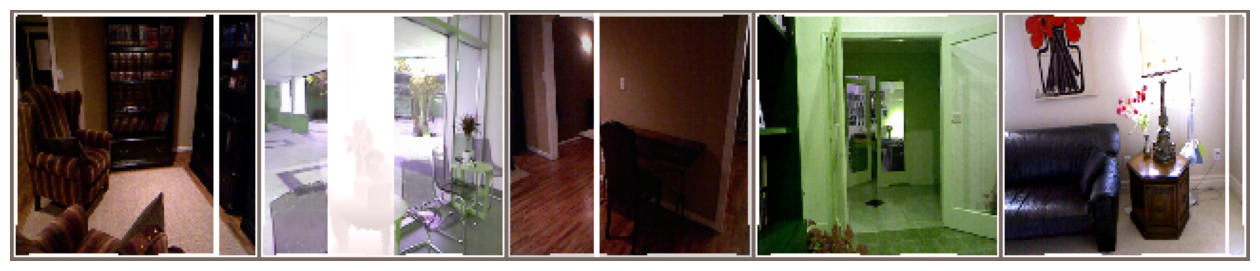

 2024-08-27 16:11:04,355 - WARNING -image.py - _normalize_image_array >> Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


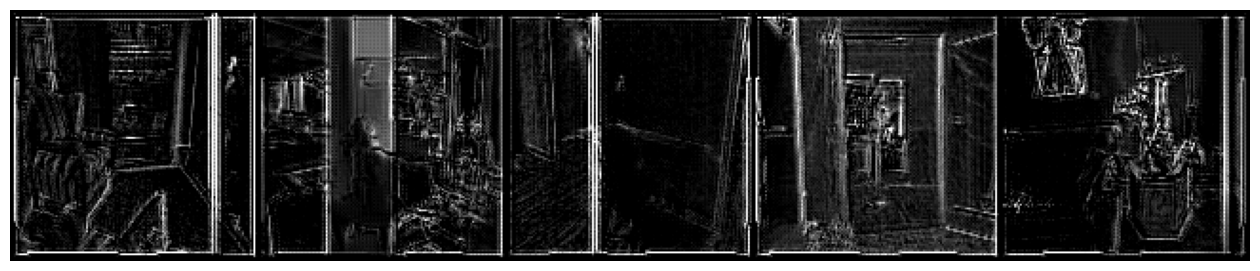

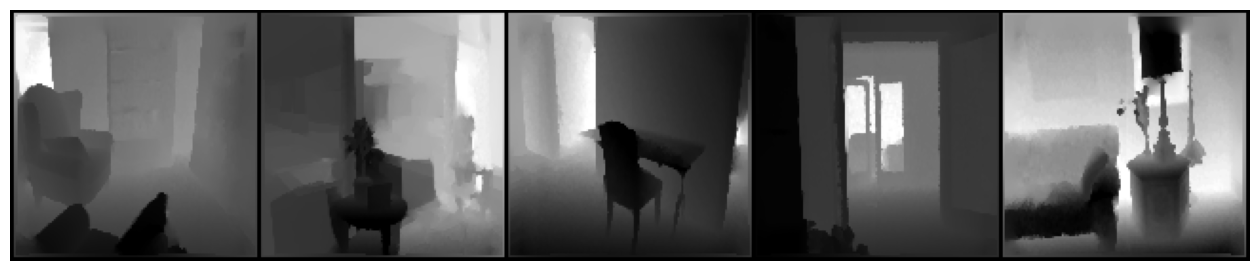

In [6]:
# for samples, _ in iter(dataloaders['train']):
batch = next(iter(train_loader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['rgb_img'])
imgshow(grid_imgs)

pred_samples = model(batch['rgb_img'].to(device))

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(pred_samples.cpu())
imgshow(grid_imgs, pred=True)

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['depth_raw_norm'])
imgshow(grid_imgs, pred=True)

In [ ]:
import pandas as pd
import torch

def abs_relative_difference(output, target, valid_mask=None):
    actual_output = output
    actual_target = target
    abs_relative_diff = torch.abs(actual_output - actual_target) / actual_target
    if valid_mask is not None:
        abs_relative_diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = output.shape[-1] * output.shape[-2]
    abs_relative_diff = torch.sum(abs_relative_diff, (-1, -2)) / n
    return abs_relative_diff.mean()


def squared_relative_difference(output, target, valid_mask=None):
    actual_output = output
    actual_target = target
    square_relative_diff = (
        torch.pow(torch.abs(actual_output - actual_target), 2) / actual_target
    )
    if valid_mask is not None:
        square_relative_diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = output.shape[-1] * output.shape[-2]
    square_relative_diff = torch.sum(square_relative_diff, (-1, -2)) / n
    return square_relative_diff.mean()

def i_rmse(output, target, valid_mask=None):
    output_inv = 1.0 / output
    target_inv = 1.0 / target
    diff = output_inv - target_inv
    if valid_mask is not None:
        diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = output.shape[-1] * output.shape[-2]
    diff2 = torch.pow(diff, 2)
    mse = torch.sum(diff2, (-1, -2)) / n  # [B]
    rmse = torch.sqrt(mse)
    return rmse.mean()


def rmse_log(output, target, valid_mask=None):
    diff = torch.log(output) - torch.log(target)
    if valid_mask is not None:
        diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = output.shape[-1] * output.shape[-2]
    diff2 = torch.pow(diff, 2)
    mse = torch.sum(diff2, (-1, -2)) / n  # [B]
    rmse = torch.sqrt(mse)
    return rmse.mean()


def log10(output, target, valid_mask=None):
    if valid_mask is not None:
        diff = torch.abs(
            torch.log10(output[valid_mask]) - torch.log10(target[valid_mask])
        )
    else:
        diff = torch.abs(torch.log10(output) - torch.log10(target))
    return diff.mean()

def silog_rmse(depth_pred, depth_gt, valid_mask=None):
    diff = torch.log(depth_pred) - torch.log(depth_gt)
    if valid_mask is not None:
        diff[~valid_mask] = 0
        n = valid_mask.sum((-1, -2))
    else:
        n = depth_gt.shape[-2] * depth_gt.shape[-1]

    diff2 = torch.pow(diff, 2)

    first_term = torch.sum(diff2, (-1, -2)) / n
    second_term = torch.pow(torch.sum(diff, (-1, -2)), 2) / (n**2)
    loss = torch.sqrt(torch.mean(first_term - second_term)) * 100
    return loss

In [11]:
import pandas as pd 

tr_abs = pd.read_csv('./test_abs/training_record/train_record.csv')
tr_rel = pd.read_csv('./test_rel/training_record/train_record.csv')
val_abs = pd.read_csv('./test_abs/evaluation_record/eval_record.csv')
val_rel = pd.read_csv('./test_rel/evaluation_record/eval_record.csv')

In [ ]:
import matplotlib.pyplot as plt

for metric_name in tr_abs.columns[1:]:
    fig, (a1,a2) = plt.subplots(1,2)
    fig.suptitle(metric_name)
    a1.plot(tr_abs['epoch'], tr_abs[metric_name], label = 'tr')
    a1.plot(val_abs['epoch'], val_abs[metric_name], label = 'val')
    a1.legend()
    
    a2.plot(tr_rel['epoch'], tr_rel[metric_name], label = 'tr')
    a2.plot(val_rel['epoch'], val_rel[metric_name], label = 'val')
    a2.legend()
    plt.show()